# Tooth Segmentation Inference

This notebook loads the pretrained U-Net model and runs inference on dental panoramic X-ray images.

**Pretrained model:** `output/models/dental_xray_seg.h5`

**Features:**
- Load and preprocess dental X-ray images
- Run U-Net segmentation
- Post-processing with Connected Component Analysis (CCA)
- Tooth counting and measurement
- **FDI tooth numbering** (automatic quadrant detection with K-Means clustering)
- **Edentulous zone detection** (missing teeth gap measurement)

In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
# Setup paths
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve()
sys.path.insert(0, str(PROJECT_ROOT))

from config import DATA_DIR, OUTPUT_DIR, PREDICTIONS_DIR, MODELS_DIR, ensure_dirs
ensure_dirs()

print(f"Project root: {PROJECT_ROOT}")
print(f"Models directory: {MODELS_DIR}")

Project root: /Users/huy/src/dentalml/reference_projects/Segmentation-of-Teeth-in-Panoramic-X-ray-Image-Using-U-Net
Models directory: /Users/huy/src/dentalml/reference_projects/Segmentation-of-Teeth-in-Panoramic-X-ray-Image-Using-U-Net/output/models


In [40]:
# Load pretrained model
# Note: Due to Keras version differences, we rebuild the architecture and load weights only
import tensorflow as tf
from model import UNET

MODEL_PATH = MODELS_DIR / 'dental_xray_seg.h5'
if not MODEL_PATH.exists():
    raise FileNotFoundError(f"Model not found at {MODEL_PATH}. Run Main.ipynb first to train.")

# Rebuild model architecture (avoids Keras version compatibility issues)
model = UNET(input_shape=(512, 512, 1), last_activation='sigmoid')

# Load weights from the saved H5 file
model.load_weights(str(MODEL_PATH))

print(f"Loaded model weights from: {MODEL_PATH}")
print(f"Input shape: {model.input_shape}")
print(f"Output shape: {model.output_shape}")

Loaded model weights from: /Users/huy/src/dentalml/reference_projects/Segmentation-of-Teeth-in-Panoramic-X-ray-Image-Using-U-Net/output/models/dental_xray_seg.h5
Input shape: (None, 512, 512, 1)
Output shape: (None, 512, 512, 1)


In [41]:
# Helper functions for inference
import numpy as np
from PIL import Image
import cv2

def load_and_preprocess(image_path: Path, target_size: tuple = (512, 512)) -> tuple[np.ndarray, np.ndarray]:
    """
    Load and preprocess an X-ray image for inference.
    
    Returns:
        preprocessed: (1, 512, 512, 1) float32 array normalized to [0, 1]
        original: Original image as numpy array
    """
    img = Image.open(image_path)
    original = np.array(img)
    
    # Resize to model input size
    img_resized = img.resize(target_size, Image.LANCZOS)
    img_array = np.array(img_resized)
    
    # Convert to grayscale if needed
    if len(img_array.shape) > 2:
        img_array = img_array[:, :, 0]
    
    # Normalize and reshape
    preprocessed = img_array.astype(np.float32) / 255.0
    preprocessed = preprocessed.reshape(1, target_size[0], target_size[1], 1)
    
    return preprocessed, original


def run_inference(model, image: np.ndarray, threshold: float = 0.25) -> np.ndarray:
    """
    Run segmentation inference.
    
    Args:
        model: Loaded Keras model
        image: Preprocessed image (1, H, W, 1)
        threshold: Binarization threshold
    
    Returns:
        Binary mask (H, W)
    """
    prediction = model.predict(image, verbose=0)
    mask = prediction[0, :, :, 0]
    binary_mask = (mask > threshold).astype(np.uint8) * 255
    return mask, binary_mask


print("Helper functions loaded.")

Helper functions loaded.


## Single Image Inference

Select an image from the dataset or provide your own path.

In [42]:
# List available images
from natsort import natsorted

IMAGES_DIR = DATA_DIR / 'Images'
available_images = natsorted(list(IMAGES_DIR.glob('*.png')))
print(f"Found {len(available_images)} images in {IMAGES_DIR}")
print(f"\nFirst 10 images:")
for img in available_images[:10]:
    print(f"  - {img.name}")

Found 116 images in /Users/huy/src/dentalml/reference_projects/Segmentation-of-Teeth-in-Panoramic-X-ray-Image-Using-U-Net/data/Images

First 10 images:
  - 1.png
  - 2.png
  - 3.png
  - 4.png
  - 5.png
  - 6.png
  - 7.png
  - 8.png
  - 9.png
  - 10.png


In [43]:
# Select image for inference
# Change this to test different images
IMAGE_INDEX = 107  # Test set image (indices 106-116 are test set)

image_path = IMAGES_DIR / f"{IMAGE_INDEX}.png"
if not image_path.exists():
    raise FileNotFoundError(f"Image not found: {image_path}")

print(f"Selected image: {image_path}")

Selected image: /Users/huy/src/dentalml/reference_projects/Segmentation-of-Teeth-in-Panoramic-X-ray-Image-Using-U-Net/data/Images/107.png


In [44]:
# Run inference
preprocessed, original = load_and_preprocess(image_path)
raw_prediction, binary_mask = run_inference(model, preprocessed, threshold=0.25)

print(f"Original image shape: {original.shape}")
print(f"Prediction shape: {raw_prediction.shape}")
print(f"Prediction value range: [{raw_prediction.min():.3f}, {raw_prediction.max():.3f}]")

Original image shape: (1300, 3126)
Prediction shape: (512, 512)
Prediction value range: [0.000, 1.000]


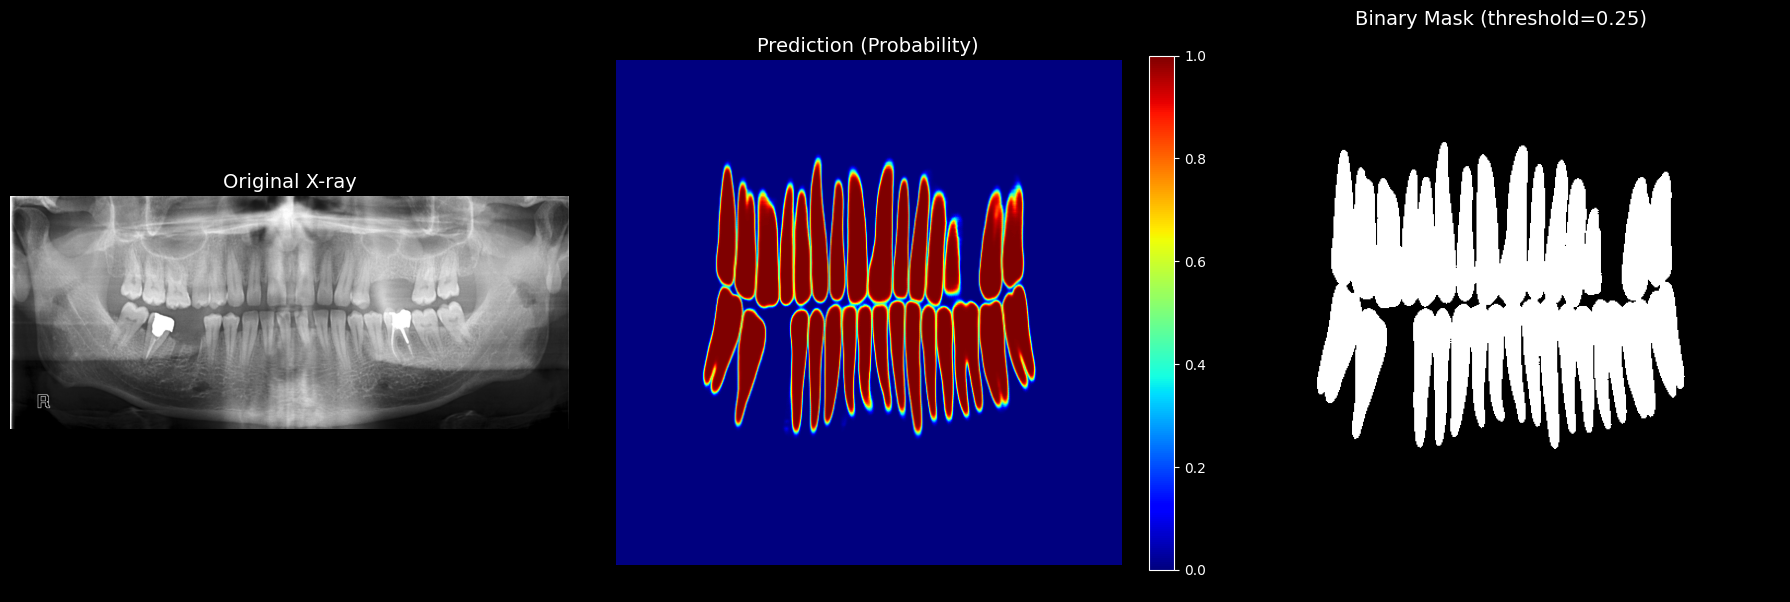

In [45]:
# Visualize results
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original image
axes[0].imshow(original, cmap='gray')
axes[0].set_title('Original X-ray', fontsize=14)
axes[0].axis('off')

# Raw prediction (probability map)
im = axes[1].imshow(raw_prediction, cmap='jet', vmin=0, vmax=1)
axes[1].set_title('Prediction (Probability)', fontsize=14)
axes[1].axis('off')
plt.colorbar(im, ax=axes[1], fraction=0.046)

# Binary mask
axes[2].imshow(binary_mask, cmap='gray')
axes[2].set_title('Binary Mask (threshold=0.25)', fontsize=14)
axes[2].axis('off')

plt.tight_layout()
plt.show()

## Overlay Visualization

Overlay segmentation contours on the original image.

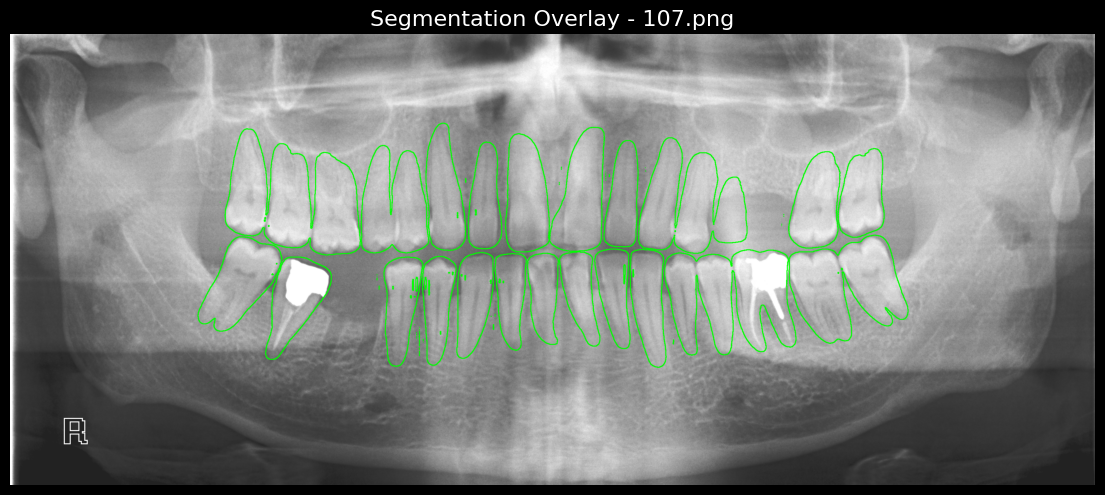

In [46]:
# Resize prediction to original image size and create overlay
prediction_resized = cv2.resize(raw_prediction, (original.shape[1], original.shape[0]), 
                                 interpolation=cv2.INTER_LANCZOS4)

# Create binary mask at original resolution
mask_uint8 = np.uint8(prediction_resized * 255)
_, mask_binary = cv2.threshold(mask_uint8, thresh=255 // 2, maxval=255, type=cv2.THRESH_BINARY)

# Find and draw contours
contours, _ = cv2.findContours(mask_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Create overlay image
if len(original.shape) == 2:
    overlay = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
else:
    overlay = original.copy()

cv2.drawContours(overlay, contours, -1, (0, 255, 0), 2)

# Display
plt.figure(figsize=(14, 10))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title(f'Segmentation Overlay - {image_path.name}', fontsize=16)
plt.axis('off')
plt.show()

## Connected Component Analysis (CCA)

Post-processing to count teeth and measure dimensions.

In [47]:
from CCA_Analysis import CCA_Analysis

# Load original image in BGR format for CCA
img_bgr = cv2.imread(str(image_path))

# Prepare prediction for CCA (needs to be BGR format)
prediction_bgr = cv2.cvtColor(mask_uint8, cv2.COLOR_GRAY2BGR)
prediction_bgr = cv2.resize(prediction_bgr, (img_bgr.shape[1], img_bgr.shape[0]))

# Run CCA analysis
# erode_iteration: higher = more separation between teeth
# open_iteration: higher = less noise
cca_result, teeth_count = CCA_Analysis(
    orig_image=img_bgr.copy(),
    predict_image=prediction_bgr,
    erode_iteration=3,
    open_iteration=2
)

print(f"Detected teeth count: {teeth_count}")

Detected teeth count: 29


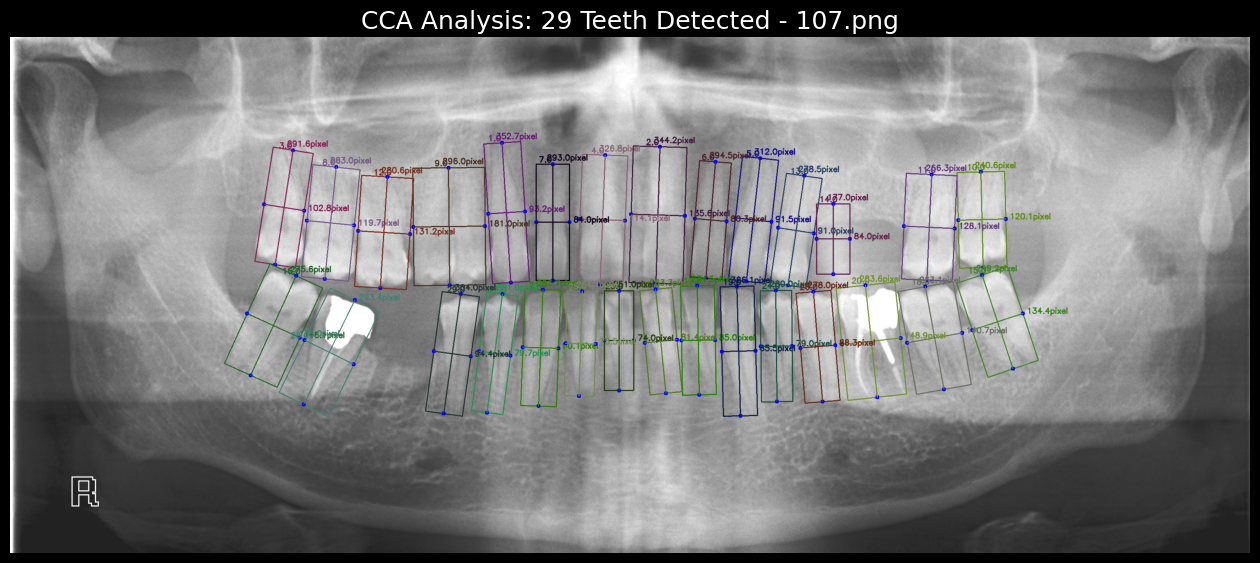

In [48]:
# Display CCA result
plt.figure(figsize=(16, 12))
plt.imshow(cv2.cvtColor(cca_result, cv2.COLOR_BGR2RGB))
plt.title(f'CCA Analysis: {teeth_count} Teeth Detected - {image_path.name}', fontsize=18)
plt.axis('off')
plt.show()

## Edentulous Zone Analysis with FDI Numbering

Detect missing teeth zones and assign FDI (Fédération Dentaire Internationale) numbers to each detected tooth.

**Features:**
- Automatic arch separation (upper/lower) using K-Means clustering
- Quadrant assignment (Q1-Q4) based on tooth position
- FDI numbering (11-18, 21-28, 31-38, 41-48)
- Gap detection between adjacent teeth
- Edentulous zone measurement (width, height, area in pixels)

In [96]:
# Import the tooth analysis module
from tooth_analysis import (
    analyze_dental_panorama,
    visualize_analysis,
    print_analysis_report
)

# Run the full dental analysis on the prediction
# prediction_bgr is already prepared from the CCA section above
analysis_result = analyze_dental_panorama(
    prediction_mask=prediction_bgr,
    image_shape=img_bgr.shape[:2],
    erode_iterations=3,
    open_iterations=2,
    min_tooth_area=2000,
    gap_threshold=2,
)

print(f"Analysis complete!")
print(f"Detected teeth: {analysis_result.total_detected}")
print(f"Missing teeth: {analysis_result.total_missing}")
print(f"Reference count: {analysis_result.reference_count}")

Analysis complete!
Detected teeth: 29
Missing teeth: 2
Reference count: 31


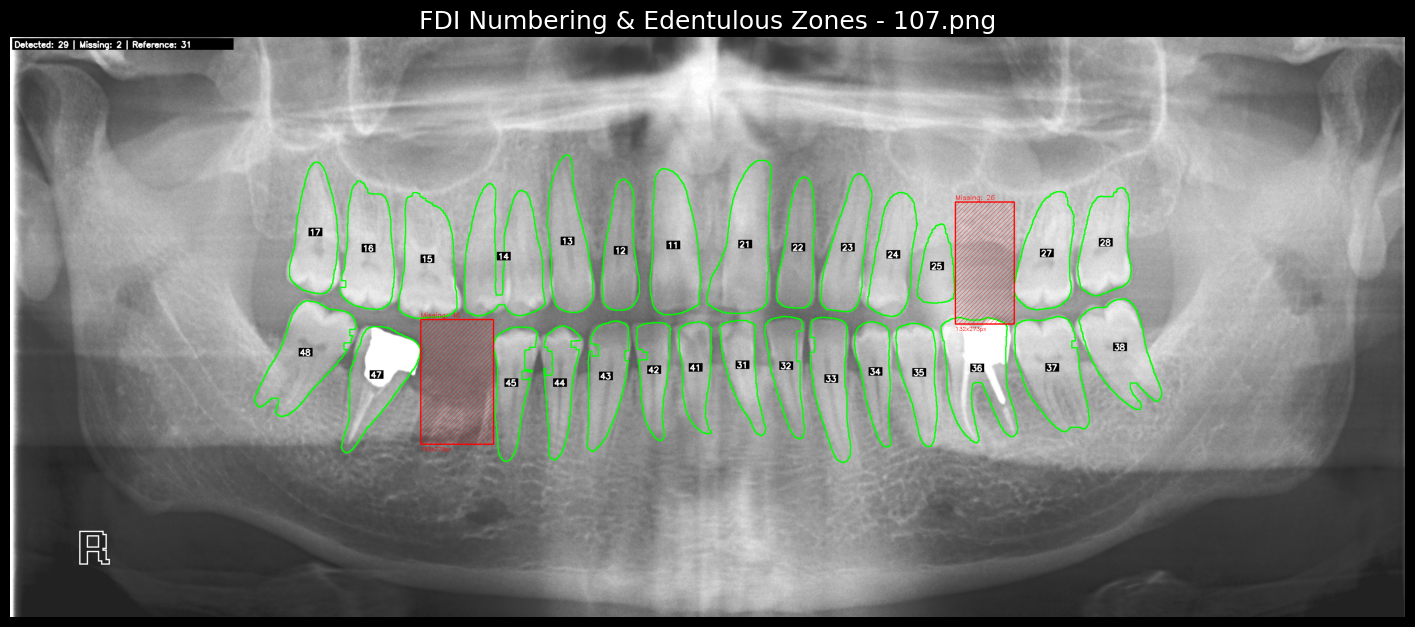

In [93]:
# Visualize the analysis with FDI labels and edentulous zones
analysis_viz = visualize_analysis(
    original_image=img_bgr,
    result=analysis_result,
    show_fdi_labels=True,
    show_zones=True,
    show_measurements=True
)

# Display
plt.figure(figsize=(18, 12))
plt.imshow(cv2.cvtColor(analysis_viz, cv2.COLOR_BGR2RGB))
plt.title(f'FDI Numbering & Edentulous Zones - {image_path.name}', fontsize=18)
plt.axis('off')
plt.show()

In [95]:
# Print detailed analysis report
_ = print_analysis_report(analysis_result)

DENTAL PANORAMA ANALYSIS REPORT

Total teeth detected: 29
Total missing teeth: 2
Reference count: 31

QUADRANT BREAKDOWN:
----------------------------------------
  Q1 (Upper Right):
    Detected: 7 / 7
    Avg tooth width: 121.3px
  Q2 (Upper Left):
    Detected: 7 / 8
    Avg tooth width: 114.6px
  Q3 (Lower Left):
    Detected: 8 / 8
    Avg tooth width: 123.6px
  Q4 (Lower Right):
    Detected: 7 / 8
    Avg tooth width: 119.6px

EDENTULOUS ZONES:
----------------------------------------
  Zone 1 (Q2):
    Missing FDI: [26]
    Between: 25 - 27
    Size: 132x273px (36036px^2)
  Zone 2 (Q4):
    Missing FDI: [46]
    Between: 45 - 47
    Size: 163x279px (45477px^2)



In [53]:
import pandas as pd
# Show detected teeth details by quadrant
teeth_data = []
for tooth in sorted(analysis_result.detected_teeth, key=lambda t: t.fdi_number or 0):
    teeth_data.append({
        'FDI': tooth.fdi_number,
        'Quadrant': tooth.quadrant,
        'Centroid X': int(tooth.centroid[0]),
        'Centroid Y': int(tooth.centroid[1]),
        'Width': int(tooth.width),
        'Height': int(tooth.height),
        'Area': tooth.area
    })

df_teeth = pd.DataFrame(teeth_data)
print("Detected Teeth Details:")
print(df_teeth.to_string(index=False))

# Edentulous zones summary
if analysis_result.edentulous_zones:
    print("\n\nEdentulous Zones:")
    zones_data = []
    for zone in analysis_result.edentulous_zones:
        zones_data.append({
            'Quadrant': zone.quadrant,
            'Missing FDI': str(zone.missing_fdi_numbers),
            'Width (px)': zone.bbox[2],
            'Height (px)': zone.bbox[3],
            'Area (px^2)': zone.area,
            'Missing Count': zone.missing_count
        })
    df_zones = pd.DataFrame(zones_data)
    print(df_zones.to_string(index=False))
else:
    print("\n\nNo edentulous zones detected - all teeth appear present!")

Detected Teeth Details:
 FDI  Quadrant  Centroid X  Centroid Y  Width  Height    Area
  11         1        1486         474    115     328 29417.5
  12         1        1368         486     85     294 17697.0
  13         1        1249         465    102     353 24277.5
  14         1        1106         499    182     297 36888.0
  15         1         935         505    132     282 28523.5
  16         1         803         481    123     288 26440.5
  17         1         684         445    110     295 22872.5
  21         2        1647         472    145     343 32188.5
  22         2        1766         479     87     294 17848.0
  23         2        1877         479    115     310 21338.0
  24         2        1979         495    113     278 21180.5
  25         2        2077         521     85     178 10870.0
  27         2        2323         492    136     265 25534.0
  28         2        2455         468    121     243 21829.0
  31         3        1641         742    104 

## Batch Inference on Test Set

Run inference on all test images (indices 106-116).

In [54]:
# Process test set images
TEST_INDICES = range(106, 117)  # Test set: images 106-116

results = []
for idx in TEST_INDICES:
    test_img_path = IMAGES_DIR / f"{idx}.png"
    if not test_img_path.exists():
        print(f"Skipping {idx}: not found")
        continue
    
    # Run inference
    preprocessed, original = load_and_preprocess(test_img_path)
    raw_pred, binary_mask = run_inference(model, preprocessed)
    
    # CCA analysis
    test_img_bgr = cv2.imread(str(test_img_path))
    pred_resized = cv2.resize(raw_pred, (test_img_bgr.shape[1], test_img_bgr.shape[0]))
    pred_bgr = cv2.cvtColor(np.uint8(pred_resized * 255), cv2.COLOR_GRAY2BGR)
    _, teeth_count = CCA_Analysis(test_img_bgr.copy(), pred_bgr, erode_iteration=3, open_iteration=2)
    
    results.append({
        'image': idx,
        'teeth_count': teeth_count,
        'prediction_mean': raw_pred.mean(),
        'prediction_max': raw_pred.max()
    })
    print(f"Image {idx}: {teeth_count} teeth detected")

print(f"\nProcessed {len(results)} images")

Image 106: 28 teeth detected
Image 107: 27 teeth detected
Image 108: 16 teeth detected
Image 109: 27 teeth detected
Image 110: 17 teeth detected
Image 111: 25 teeth detected
Image 112: 23 teeth detected
Image 113: 12 teeth detected
Image 114: 21 teeth detected
Image 115: 26 teeth detected
Image 116: 26 teeth detected

Processed 11 images


In [55]:
# Summary statistics

df = pd.DataFrame(results)
print("Test Set Results:")
print(df.to_string(index=False))
print(f"\nAverage teeth count: {df['teeth_count'].mean():.1f}")
print(f"Teeth count range: {df['teeth_count'].min()} - {df['teeth_count'].max()}")

Test Set Results:
 image  teeth_count  prediction_mean  prediction_max
   106           28         0.231874        0.999872
   107           27         0.197435        0.999930
   108           16         0.161123        0.999786
   109           27         0.232331        0.999884
   110           17         0.192617        0.999918
   111           25         0.213226        0.999899
   112           23         0.224536        0.999886
   113           12         0.255965        0.999780
   114           21         0.198088        0.999964
   115           26         0.227181        0.999914
   116           26         0.207349        0.999907

Average teeth count: 22.5
Teeth count range: 12 - 28


## Custom Image Inference

Provide your own X-ray image path for inference.

In [56]:
def inference_on_custom_image(image_path: str, threshold: float = 0.25, show_cca: bool = True):
    """
    Run full inference pipeline on a custom image.
    
    Args:
        image_path: Path to the X-ray image
        threshold: Binarization threshold (default 0.25)
        show_cca: Whether to run and display CCA analysis
    """
    image_path = Path(image_path)
    if not image_path.exists():
        raise FileNotFoundError(f"Image not found: {image_path}")
    
    # Run inference
    preprocessed, original = load_and_preprocess(image_path)
    raw_pred, binary_mask = run_inference(model, preprocessed, threshold)
    
    # Basic visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title('Original', fontsize=14)
    axes[0].axis('off')
    
    axes[1].imshow(raw_pred, cmap='jet', vmin=0, vmax=1)
    axes[1].set_title('Prediction', fontsize=14)
    axes[1].axis('off')
    
    axes[2].imshow(binary_mask, cmap='gray')
    axes[2].set_title(f'Binary (t={threshold})', fontsize=14)
    axes[2].axis('off')
    plt.tight_layout()
    plt.show()
    
    # CCA analysis
    if show_cca:
        img_bgr = cv2.imread(str(image_path))
        pred_resized = cv2.resize(raw_pred, (img_bgr.shape[1], img_bgr.shape[0]))
        pred_bgr = cv2.cvtColor(np.uint8(pred_resized * 255), cv2.COLOR_GRAY2BGR)
        cca_result, teeth_count = CCA_Analysis(img_bgr.copy(), pred_bgr, 
                                                erode_iteration=3, open_iteration=2)
        
        plt.figure(figsize=(14, 10))
        plt.imshow(cv2.cvtColor(cca_result, cv2.COLOR_BGR2RGB))
        plt.title(f'CCA: {teeth_count} Teeth', fontsize=16)
        plt.axis('off')
        plt.show()
        
        return raw_pred, teeth_count
    
    return raw_pred, None

print("Custom inference function ready.")
print("Usage: inference_on_custom_image('/path/to/your/xray.png')")

Custom inference function ready.
Usage: inference_on_custom_image('/path/to/your/xray.png')


In [57]:
# Example: run on a specific image
# Uncomment and modify the path to test your own image:

# prediction, teeth_count = inference_on_custom_image(
#     '/path/to/your/dental_xray.png',
#     threshold=0.25,
#     show_cca=True
# )

## Save Predictions

Save predictions for later analysis.

In [58]:
def save_prediction(image_path: str, output_dir: Path = PREDICTIONS_DIR, threshold: float = 0.25):
    """
    Run inference and save prediction to file.
    
    Saves:
    - {name}_prediction.png: Raw probability map
    - {name}_binary.png: Binary mask
    - {name}_overlay.png: Contour overlay on original
    """
    image_path = Path(image_path)
    name = image_path.stem
    
    # Run inference
    preprocessed, original = load_and_preprocess(image_path)
    raw_pred, binary_mask = run_inference(model, preprocessed, threshold)
    
    # Save raw prediction
    plt.imsave(str(output_dir / f"{name}_prediction.png"), raw_pred, cmap='gray')
    
    # Save binary mask
    cv2.imwrite(str(output_dir / f"{name}_binary.png"), binary_mask)
    
    # Create and save overlay
    pred_resized = cv2.resize(raw_pred, (original.shape[1], original.shape[0]))
    mask_uint8 = np.uint8(pred_resized * 255)
    _, mask_bin = cv2.threshold(mask_uint8, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(mask_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(original.shape) == 2:
        overlay = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
    else:
        overlay = original.copy()
    cv2.drawContours(overlay, contours, -1, (0, 255, 0), 2)
    cv2.imwrite(str(output_dir / f"{name}_overlay.png"), overlay)
    
    print(f"Saved predictions for {name} to {output_dir}")
    return raw_pred

# Example: save prediction for image 107
save_prediction(IMAGES_DIR / "107.png")

Saved predictions for 107 to /Users/huy/src/dentalml/reference_projects/Segmentation-of-Teeth-in-Panoramic-X-ray-Image-Using-U-Net/output/predictions


array([[3.9882795e-03, 1.3864979e-04, 5.1129198e-05, ..., 1.3179470e-04,
        4.0501382e-04, 3.3286151e-03],
       [1.9730304e-03, 2.7866437e-04, 5.3467196e-05, ..., 2.0253012e-04,
        5.7509256e-04, 4.0042205e-03],
       [2.1060323e-03, 1.9140901e-04, 3.3998778e-05, ..., 7.0565671e-05,
        2.2401060e-04, 1.1881602e-03],
       ...,
       [2.4042730e-03, 2.9247857e-04, 1.9078312e-04, ..., 3.7296084e-06,
        3.0679159e-05, 6.7182654e-04],
       [4.0284661e-03, 1.1487375e-03, 5.5124785e-04, ..., 4.0104056e-05,
        1.6489413e-04, 5.3097126e-03],
       [1.2501259e-02, 8.7328656e-03, 2.5365909e-03, ..., 9.3266637e-05,
        6.4608216e-04, 7.7577741e-03]], shape=(512, 512), dtype=float32)